# DF CON VARIABLES DE 4 HORAS #

In [315]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor,RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score,root_mean_squared_error
import time


In [402]:
import numpy as np
import pandas as pd
from astral.sun import sun
from astral import LocationInfo
from skforecast.datasets import fetch_dataset
from feature_engine.datetime import DatetimeFeatures
from feature_engine.creation import CyclicalFeatures
from feature_engine.timeseries.forecasting import WindowFeatures

In [403]:
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from skforecast.plot import plot_residuals, calculate_lag_autocorrelation
import plotly.graph_objects as go
import plotly.io as pio
import plotly.offline as poff
pio.templates.default = "seaborn"
poff.init_notebook_mode(connected=True)
plt.style.use('seaborn-v0_8-darkgrid')

In [407]:
import xgboost
import lightgbm
import catboost
import sklearn
import shap
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.preprocessing import (
    OneHotEncoder,
    OrdinalEncoder,
    FunctionTransformer,
    PolynomialFeatures,
)
from sklearn.feature_selection import RFECV
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer, make_column_selector

import skforecast
from skforecast.recursive import ForecasterEquivalentDate, ForecasterRecursive
from skforecast.model_selection import (
    TimeSeriesFold,
    OneStepAheadFold,
    bayesian_search_forecaster,
    backtesting_forecaster,
)
from skforecast.preprocessing import RollingFeatures
from skforecast.feature_selection import select_features
from skforecast.metrics import calculate_coverage

In [3]:
import requests

url = "https://api.binance.com/api/v3/exchangeInfo"
data = requests.get(url).json()

# Extraer todos los símbolos disponibles
symbols = [s['symbol'] for s in data['symbols']]
print(symbols[:20])  # mostrar los primeros 20

['ETHBTC', 'LTCBTC', 'BNBBTC', 'NEOBTC', 'QTUMETH', 'EOSETH', 'SNTETH', 'BNTETH', 'BCCBTC', 'GASBTC', 'BNBETH', 'BTCUSDT', 'ETHUSDT', 'HSRBTC', 'OAXETH', 'DNTETH', 'MCOETH', 'ICNETH', 'MCOBTC', 'WTCBTC']


In [42]:
def get_binance_ohlcv(symbol, interval="1d", days=6000):
    """
    Descarga velas OHLCV desde Binance.
    symbol: par de trading (ej: BTCUSDT)
    interval: intervalo de vela (ej: 1h, 1d, 15m)
    days: días de datos hacia atrás
    """
    base_url = "https://api.binance.com/api/v3/klines"
    
    # Binance limita 1000 velas por request → dividir en chunks
    limit = 1000
    ms_interval = 60 * 60 * 1000  # 1h en milisegundos
    if interval == "1d":
        ms_interval = 24 * 60 * 60 * 1000
    
    end_time = int(time.time() * 1000)  # ahora en ms
    start_time = end_time - days * 24 * 60 * 60 * 1000
    
    all_data = []
    
    while start_time < end_time:
        params = {
            "symbol": symbol,
            "interval": interval,
            "startTime": start_time,
            "limit": limit
        }
        resp = requests.get(base_url, params=params)
        data = resp.json()
        
        if not data:
            break
        
        all_data.extend(data)
        
        # avanzar el start_time al último timestamp + intervalo
        last_open_time = data[-1][0]
        start_time = last_open_time + ms_interval
        
        time.sleep(0.2)  # para no sobrecargar la API
    
    # convertir a DataFrame
    df = pd.DataFrame(all_data, columns=[
        "open_time", "open", "high", "low", "close", "volume",
        "close_time", "quote_asset_volume", "number_of_trades",
        "taker_buy_base", "taker_buy_quote", "ignore"
    ])
    
    # limpiar tipos de datos
    df["open_time"] = pd.to_datetime(df["open_time"], unit="ms")
    df["close_time"] = pd.to_datetime(df["close_time"], unit="ms")
    for col in ["open", "high", "low", "close", "volume"]:
        df[col] = df[col].astype(float)
    
    return df[["open_time", "open", "high", "low", "close", "volume","number_of_trades"]]

In [472]:
df=get_binance_ohlcv('ETHUSDT')

In [473]:
df

,open_time,open,high,low,close,volume,number_of_trades
0,2017-08-17,301.13,312.18,298.00,302.00,7030.71034,4522
1,2017-08-18,302.00,311.79,283.94,293.96,9537.84646,5658
2,2017-08-19,293.31,299.90,278.00,290.91,2146.19773,1795
3,2017-08-20,289.41,300.53,282.85,299.10,2510.13871,2038
4,2017-08-21,299.10,346.52,294.60,323.29,5219.44542,3925
...,...,...,...,...,...,...,...
2967,2025-10-01,4145.15,4355.46,4123.08,4348.03,507026.38220,4138481
2968,2025-10-02,4348.03,4516.74,4332.73,4484.35,526411.15710,4441183
2969,2025-10-03,4484.35,4591.59,4428.00,4512.87,485684.02670,5149648
2970,2025-10-04,4512.88,4517.93,4440.00,4487.15,199732.70880,2252261


In [474]:
#vamos a ver como funciona sin el volumen
df_porcentual=pd.DataFrame(columns=["4hora%","dia%","2dias%","1semana%"])
def porcentaje (df,columna_objetivo,n_de_intervalos,columna_nueva):

    for i in range(n_de_intervalos,len(df[columna_objetivo])):
        cambio=(df[columna_objetivo][i-n_de_intervalos]-df[columna_objetivo][i])/df[columna_objetivo][i-n_de_intervalos]
        df.loc[i,columna_nueva]=cambio*100
porcentaje(df,"close",1,"1dia%")
porcentaje(df,"close",2,"2dias%")
porcentaje(df,"close",7,"1semana%")
porcentaje(df,"close",14,"2semanas%")
porcentaje(df,"close",30,"1mes%")


#porcentaje(df,"close",1,"1hora%")
#porcentaje(df,"close",4,"4hora%")
#porcentaje(df,"close",8,"8hora%")
#porcentaje(df,"close",24,"dia%")
#porcentaje(df,"close",48,"2dias%")
#porcentaje(df,"close",24*7,"1semana%")
#porcentaje(df,"close",24*7*2,"2semanas%")
#porcentaje(df,"close",24*7*4,"1mes%")
#df.dropna(inplace=True)
#df.reset_index(drop=True,inplace=True)

In [46]:
df.dropna(inplace=True)
df.reset_index(drop=True,inplace=True)

In [475]:
df_porcentual=df

In [476]:
df_porcentual["pred_dia%"]=df_porcentual["1dia%"].shift(-1)
#df_porcentual["pred_dia%"]=df_porcentual["dia%"].shift(-24)

In [477]:

def calcular_RSI(df, column="close", period=21):
    """
    Calcula el RSI (Relative Strength Index) de un DataFrame.
    
    Parámetros:
        df: DataFrame con la columna de precios.
        column: columna sobre la cual calcular el RSI (por defecto 'close').
        period: ventana del RSI (por defecto 14).
        
    Retorna:
        DataFrame con una columna adicional 'RSI'.
    """
    # Calcular diferencias entre cierres
    delta = df[column].diff()

    # Separar ganancias y pérdidas
    ganancias = delta.clip(lower=0)
    perdidas = -delta.clip(upper=0)

    # Calcular medias móviles exponenciales
    media_gan = ganancias.ewm(span=period, adjust=False).mean()
    media_per = perdidas.ewm(span=period, adjust=False).mean()

    # Calcular RS y RSI
    RS = media_gan / media_per
    RSI = 100 - (100 / (1 + RS))

    df["RSI"] = RSI
    return df
calcular_RSI(df_porcentual)

,open_time,open,high,low,close,volume,number_of_trades,1dia%,2dias%,1semana%,2semanas%,1mes%,pred_dia%,RSI
0,2017-08-17,301.13,312.18,298.00,302.00,7030.71034,4522,NaN,NaN,NaN,NaN,NaN,2.662252,NaN
1,2017-08-18,302.00,311.79,283.94,293.96,9537.84646,5658,2.662252,NaN,NaN,NaN,NaN,1.037556,0.000000
2,2017-08-19,293.31,299.90,278.00,290.91,2146.19773,1795,1.037556,3.672185,NaN,NaN,NaN,-2.815304,0.000000
3,2017-08-20,289.41,300.53,282.85,299.10,2510.13871,2038,-2.815304,-1.748537,NaN,NaN,NaN,-8.087596,9.743778
4,2017-08-21,299.10,346.52,294.60,323.29,5219.44542,3925,-8.087596,-11.130590,NaN,NaN,NaN,4.172724,31.446025
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2967,2025-10-01,4145.15,4355.46,4123.08,4348.03,507026.38220,4138481,-4.894395,-3.154396,-4.700913,5.282614,-0.777147,-3.135213,53.991254
2968,2025-10-02,4348.03,4516.74,4332.73,4484.35,526411.15710,4441183,-3.135213,-8.183057,-15.744278,2.251911,-3.648446,-0.635990,59.480449
2969,2025-10-03,4484.35,4591.59,4428.00,4512.87,485684.02670,5149648,-0.635990,-3.791142,-11.919677,-0.990917,-1.402327,0.569926,60.563258
2970,2025-10-04,4512.88,4517.93,4440.00,4487.15,199732.70880,2252261,0.569926,-0.062439,-11.665646,-0.150209,-4.411816,-1.184493,58.999219


In [478]:
df_porcentual.set_index("open_time", inplace=True)

In [421]:
calculate_lag_autocorrelation(
    data    = df_porcentual["close"],
    n_lags  = 60,
    sort_by = "partial_autocorrelation_abs"
).head(10)

,lag,partial_autocorrelation_abs,partial_autocorrelation,autocorrelation_abs,autocorrelation
0,1,0.997931,0.997931,0.997592,0.997592
1,10,0.053386,-0.053386,0.979066,0.979066
2,41,0.043214,-0.043214,0.910459,0.910459
3,2,0.033949,0.033949,0.995330,0.995330
4,4,0.033262,0.033262,0.991025,0.991025
5,14,0.031249,-0.031249,0.970513,0.970513
6,7,0.031085,0.031085,0.984900,0.984900
7,37,0.029326,-0.029326,0.919718,0.919718
8,32,0.027885,-0.027885,0.931193,0.931193
9,46,0.027322,0.027322,0.898720,0.898720


In [422]:
# Crear un baseline: valor de la misma hora del día anterior
# ==============================================================================
forecaster = ForecasterEquivalentDate(
                offset    = pd.DateOffset(days=1),
                n_offsets = 1
             )

# Entremaiento del forecaster
# ==============================================================================
forecaster.fit(y=df_porcentual.loc[:"2025-10-04", "close"])
forecaster

TypeError: If `offset` is a pandas DateOffset, the index of `y` must be a pandas DatetimeIndex with frequency.

In [20]:
df_porcentual

,open_time,open,high,low,close,volume,1dia%,2dias%,1semana%,2semanas%,1mes%,pred_dia%,RSI
0,2017-09-16,3674.01,3950.00,3470.66,3714.95,1297.563953,-0.404054,-16.491900,12.770234,16.931268,13.305002,0.402697,NaN
1,2017-09-17,3685.23,3748.21,3499.02,3699.99,682.171210,0.402697,0.000270,10.419890,17.943572,9.940195,-9.054619,0.000000
2,2017-09-18,3690.00,4123.20,3690.00,4035.01,1030.006455,-9.054619,-8.615459,4.121688,1.587762,2.535519,3.097142,69.130453
3,2017-09-19,4060.00,4089.97,3830.91,3910.04,902.332129,3.097142,-5.677042,6.092629,10.453066,4.313203,0.256775,53.854204
4,2017-09-20,3910.04,4046.08,3820.00,3900.00,720.935076,0.256775,3.345964,1.132915,15.580213,2.888446,7.436154,52.822659
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2936,2025-09-30,114311.97,114792.00,112656.27,114048.93,15044.156330,0.230098,-1.680558,-1.830493,2.346138,-5.360532,-3.986061,53.821501
2937,2025-10-01,114048.94,118649.10,113966.67,118594.99,20036.395160,-3.986061,-3.746791,-4.666958,-1.844091,-8.566268,-1.631064,66.146607
2938,2025-10-02,118594.99,121022.07,118279.31,120529.35,19670.835030,-1.631064,-5.682140,-10.582975,-2.951837,-8.350718,-1.412643,69.906060
2939,2025-10-03,120529.35,123894.99,119248.30,122232.00,23936.328000,-1.412643,-3.066748,-11.481341,-5.707415,-9.423234,-0.178341,72.827718


In [479]:
def agregar_emas(df, column="close", spans=[9, 21, 50, 100,200]):

    for span in spans:
        df[f"EMA_{span}"] = df[column].ewm(span=span, adjust=False).mean()
    return df
agregar_emas(df_porcentual)

,open,high,low,close,volume,number_of_trades,1dia%,2dias%,1semana%,2semanas%,1mes%,pred_dia%,RSI,EMA_9,EMA_21,EMA_50,EMA_100,EMA_200
open_time,,,,,,,,,,,,,,,,,,
2017-08-17,301.13,312.18,298.00,302.00,7030.71034,4522,NaN,NaN,NaN,NaN,NaN,2.662252,NaN,302.000000,302.000000,302.000000,302.000000,302.000000
2017-08-18,302.00,311.79,283.94,293.96,9537.84646,5658,2.662252,NaN,NaN,NaN,NaN,1.037556,0.000000,300.392000,301.269091,301.684706,301.840792,301.920000
2017-08-19,293.31,299.90,278.00,290.91,2146.19773,1795,1.037556,3.672185,NaN,NaN,NaN,-2.815304,0.000000,298.495600,300.327355,301.262168,301.624341,301.810448
2017-08-20,289.41,300.53,282.85,299.10,2510.13871,2038,-2.815304,-1.748537,NaN,NaN,NaN,-8.087596,9.743778,298.616480,300.215778,301.177377,301.574354,301.783478
2017-08-21,299.10,346.52,294.60,323.29,5219.44542,3925,-8.087596,-11.130590,NaN,NaN,NaN,4.172724,31.446025,303.551184,302.313434,302.044539,302.004367,301.997473
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-10-01,4145.15,4355.46,4123.08,4348.03,507026.38220,4138481,-4.894395,-3.154396,-4.700913,5.282614,-0.777147,-3.135213,53.991254,4202.915757,4267.704222,4215.845064,3880.980242,3434.375157
2025-10-02,4348.03,4516.74,4332.73,4484.35,526411.15710,4441183,-3.135213,-8.183057,-15.744278,2.251911,-3.648446,-0.635990,59.480449,4259.202606,4287.399292,4226.374669,3892.928158,3444.822668
2025-10-03,4484.35,4591.59,4428.00,4512.87,485684.02670,5149648,-0.635990,-3.791142,-11.919677,-0.990917,-1.402327,0.569926,60.563258,4309.936085,4307.896629,4237.609780,3905.204234,3455.450004


In [78]:
df_porcentual

,open_time,open,high,low,close,volume,1dia%,2dias%,1semana%,2semanas%,1mes%,pred_dia%,RSI,EMA_9,EMA_21,EMA_50,EMA_100,EMA_200,resistencia
0,2017-09-16,3674.01,3950.00,3470.66,3714.95,1297.563953,-0.404054,-16.491900,12.770234,16.931268,13.305002,0.402697,39.364501,3907.513301,4117.424423,4223.084071,4256.206832,4271.115083,0
1,2017-09-17,3685.23,3748.21,3499.02,3699.99,682.171210,0.402697,0.000270,10.419890,17.943572,9.940195,-9.054619,38.986942,3866.008641,4079.475839,4202.570578,4245.192637,4265.432246,0
2,2017-09-18,3690.00,4123.20,3690.00,4035.01,1030.006455,-9.054619,-8.615459,4.121688,1.587762,2.535519,3.097142,51.104976,3899.808913,4075.433490,4195.999575,4241.030605,4263.139487,0
3,2017-09-19,4060.00,4089.97,3830.91,3910.04,902.332129,3.097142,-5.677042,6.092629,10.453066,4.313203,0.256775,47.080294,3901.855130,4060.397718,4184.785474,4234.476336,4259.626060,0
4,2017-09-20,3910.04,4046.08,3820.00,3900.00,720.935076,0.256775,3.345964,1.132915,15.580213,2.888446,7.436154,46.739082,3901.484104,4045.816107,4173.617416,4227.853042,4256.047691,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2934,2025-09-28,109635.85,112350.00,109189.99,112163.95,7542.331600,-2.305906,-2.298806,2.662743,2.692907,-3.493856,-1.915063,48.089594,111920.296574,112867.855598,113294.701610,111749.355173,106258.686629,0
2935,2025-09-29,112163.96,114400.00,111560.65,114311.96,15541.120050,-1.915063,-4.265129,-1.474439,0.899655,-5.050372,0.230098,58.375619,112398.629259,112999.137816,113334.594096,111800.099823,106338.818702,0
2936,2025-09-30,114311.97,114792.00,112656.27,114048.93,15044.156330,0.230098,-1.680558,-1.830493,2.346138,-5.360532,-3.986061,56.785792,112728.689407,113094.573469,113362.607269,111844.631114,106415.536228,0
2937,2025-10-01,114048.94,118649.10,113966.67,118594.99,20036.395160,-3.986061,-3.746791,-4.666958,-1.844091,-8.566268,-1.631064,71.995568,113901.949526,113594.611336,113567.798749,111978.301587,106536.724822,0


In [480]:
def volumen_por_precio(df, price_col="close", volume_col="volume", bins=50):
    """
    Calcula volumen por nivel de precio (Volume Profile).
    
    Parámetros:
        df: DataFrame con precios y volúmenes.
        price_col: columna de precios (por defecto 'close').
        volume_col: columna de volúmenes (por defecto 'volume').
        bins: número de intervalos de precio.
    
    Retorna:
        DataFrame con niveles de precio y volumen acumulado.
    """
    precios = df[price_col]
    volumenes = df[volume_col]

    # Crear bins de precio
    hist, edges = np.histogram(precios, bins=bins, weights=volumenes)

    # Calcular punto medio de cada bin
    price_levels = (edges[:-1] + edges[1:]) / 2

    vp = pd.DataFrame({"price_level": price_levels, "volume": hist})
    vp = vp.sort_values(by="volume", ascending=False).reset_index(drop=True)
    return vp
resistencias=volumen_por_precio(df_porcentual)

In [52]:
resistencias

,price_level,volume
0,21225.9265,2.015115e+07
1,23627.8207,1.920933e+07
2,9216.4555,1.805211e+07
3,18824.0323,1.777361e+07
4,6814.5613,1.463762e+07
5,16422.1381,1.444747e+07
6,11618.3497,7.923594e+06
7,4412.6671,7.690909e+06
8,28431.6091,7.362535e+06
9,35637.2917,4.491648e+06


In [481]:
#agregamos precios de resistencias
#vamos a poner 1 en cada zona de resistencia y 0 en donde no hay resistencias de volumen 
resis=[]
df_porcentual["resistencia"]=0
lista_redondeada_high = [round(x, 0) for x in list(df_porcentual["high"])]
lista_redondeada_low = [round(x, 0) for x in list(df_porcentual["low"])]
lista_redondeada_close = [round(x, 0) for x in list(df_porcentual["close"])]
for i in list(round(resistencias["price_level"],0)):
    if i in lista_redondeada_high:

        indice=lista_redondeada_high.index(i)
        df_porcentual.loc[indice,"resistencia"]=1
    elif i in lista_redondeada_low:

        indice=lista_redondeada_low.index(i)
        df_porcentual.loc[indice,"resistencia"]=1
    elif i in lista_redondeada_close:

        indice=lista_redondeada_close.index(i)
        df_porcentual.loc[indice,"resistencia"]=1

In [482]:
df_porcentual.dropna(inplace=True)
df_porcentual.reset_index(drop=True,inplace=True)

In [483]:
df_porcentual.columns

Index(['open', 'high', 'low', 'close', 'volume', 'number_of_trades', '1dia%',
       '2dias%', '1semana%', '2semanas%', '1mes%', 'pred_dia%', 'RSI', 'EMA_9',
       'EMA_21', 'EMA_50', 'EMA_100', 'EMA_200', 'resistencia'],
      dtype='object')

In [55]:
len(df_porcentual)

2939

In [484]:
df_porcentual

,open,high,low,close,volume,number_of_trades,1dia%,2dias%,1semana%,2semanas%,1mes%,pred_dia%,RSI,EMA_9,EMA_21,EMA_50,EMA_100,EMA_200,resistencia
0,255.99,271.81,235.51,249.31,10362.06011,8859.0,1.458498,-15.844989,15.983689,27.344524,17.447020,-3.305122,35.771216,272.733502,296.323595,306.495084,306.686866,305.146747,0.0
1,249.32,264.39,239.02,257.55,4614.53337,5277.0,-3.305122,-1.798419,12.248722,24.642303,12.386039,-14.373908,38.562048,269.696802,292.798723,304.575669,305.713858,304.673148,0.0
2,257.53,306.22,257.11,294.57,4125.97051,3440.0,-14.373908,-18.154105,0.918264,-3.805899,-1.258121,3.588281,49.422814,274.671442,292.959748,304.183290,305.493188,304.572619,0.0
3,296.00,300.00,277.41,284.00,1869.90852,1896.0,3.588281,-10.269851,3.388216,9.000609,5.048479,0.704225,46.823159,276.537153,292.145226,303.391788,305.067580,304.367916,0.0
4,284.01,294.00,275.91,282.00,1060.56734,1431.0,0.704225,4.267237,-1.838142,15.820896,12.771815,8.865248,46.316089,277.629723,291.222932,302.552894,304.610796,304.145350,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2936,4215.07,4245.00,4092.10,4145.15,391126.61720,4118784.0,1.658810,-0.072185,0.458905,7.911954,5.616793,-4.894395,43.665976,4166.637197,4259.671644,4210.449760,3871.544893,3425.192696,0.0
2937,4145.15,4355.46,4123.08,4348.03,507026.38220,4138481.0,-4.894395,-3.154396,-4.700913,5.282614,-0.777147,-3.135213,53.991254,4202.915757,4267.704222,4215.845064,3880.980242,3434.375157,0.0
2938,4348.03,4516.74,4332.73,4484.35,526411.15710,4441183.0,-3.135213,-8.183057,-15.744278,2.251911,-3.648446,-0.635990,59.480449,4259.202606,4287.399292,4226.374669,3892.928158,3444.822668,0.0
2939,4484.35,4591.59,4428.00,4512.87,485684.02670,5149648.0,-0.635990,-3.791142,-11.919677,-0.990917,-1.402327,0.569926,60.563258,4309.936085,4307.896629,4237.609780,3905.204234,3455.450004,0.0


In [465]:
relativ_error=[]
corr_direccion=0
aciertos_direccion_list=[]
error_aciertos_list=[]
y_pred_guardadas=[]
y_real_guardadas=[]
restricciones=['level_0', 'index', 'open', 'high', 'low', 'close', 'volume',
      '2dias%', '1semana%', '2semanas%', '1mes%',
       'pred_dia%', 'RSI', 'EMA_21', 'EMA_50', 'EMA_100', 'EMA_200',
        'resistencia_precio', 'distancia_resistencia_%',
       'distancia_resistencia_%_grande', 
      'fuerza_resistencia_media',
       'distancia_resistencia_%_chica', 'fuerza_resistencia_chica',
       'direccion_pred']
#📊 Features seleccionadas por Optuna:
#['number_of_trades', '1dia%', 'resistencia', 'fuerza_resistencia_grande', 'distancia_resistencia_%_media']
medir='direccion_pred'
for i in range(50):
    print(i)
    #vamos a separar los datos de entreno y los outsider
    entreno=df_porcentual[0+i:2838+i]
    outsider=df_porcentual[2838+i+1:2838+i+2]
    #print(outsider)
    outsider.reset_index(drop=True,inplace=True)
    entreno.reset_index(drop=True,inplace=True)
    #ahora ponemos el y el x
    X_entreno=entreno.drop(restricciones,axis=1)
    y=entreno[medir]
    X_train, X_test, y_train, y_test = train_test_split(X_entreno, y, test_size=0.2, random_state=42)
    #model=RandomForestRegressor( n_estimators=100, random_state=42)
    model=RandomForestClassifier( random_state=42,n_estimators= 1183, max_depth= 2, min_samples_split= 6, min_samples_leaf= 3)
#    🏆 Mejor configuración encontrada:
#'n_estimators': 1183, 'max_depth': 11, 'min_samples_split': 6, 'min_samples_leaf': 3, 'max_features': 'log2', 'use_high': False, 'use_low': False, 'use_close': False, 'use_volume': False, 'use_number_of_trades': True, 'use_1dia%': True, 'use_2dias%': False, 'use_1semana%': False, 'use_2semanas%': False, 'use_1mes%': False, 'use_RSI': False, 'use_EMA_9': False, 'use_EMA_21': False, 'use_EMA_50': False, 'use_EMA_100': False, 'use_EMA_200': False, 'use_resistencia': True, 'use_resistencia_precio': False, 'use_distancia_resistencia_%': False, 'use_distancia_resistencia_%_grande': False, 'use_fuerza_resistencia_grande': True, 'use_distancia_resistencia_%_media': True, 'use_fuerza_resistencia_media': False, 'use_distancia_resistencia_%_chica': False, 'use_fuerza_resistencia_chica': False}


    model.fit(X_train,y_train)
    X_outsider=outsider.drop(restricciones,axis=1)
    y_outsider=outsider[medir]#es el real
    predicciones_outsider=model.predict(X_outsider)
    #print(y_outsider[0])
    y_pred_guardadas.append(predicciones_outsider[0])
    y_real_guardadas.append(y_outsider[0])
    #error_relativo_porcentual=abs(y_outsider[0]-predicciones_outsider)/y_outsider[0]
    relativ_error.append(error_relativo_porcentual)
    #if y_outsider[0]*predicciones_outsider>0:
        #aciertos_direccion_list.append(predicciones_outsider)
        #error_relativo_aciertos=abs(y_outsider[0]-predicciones_outsider)/y_outsider[0]
        #error_aciertos_list.append(error_relativo_aciertos)

#error_total=abs(np.array(relativ_error).sum())/len(relativ_error)
#aciertos_direccion=len(aciertos_direccion_list)
#error_aciertos=abs(np.array(error_aciertos_list).sum())/len(error_aciertos_list)

    if predicciones_outsider[0]==y_outsider[0]:
        corr_direccion+=1
print(corr_direccion/50)


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
0.5


In [326]:
tabla_resultados=pd.DataFrame(columns=["error_total","error_aciertos","aciertos_direccion"])
tabla_resultados["error_total"]=error_total
tabla_resultados["error_aciertos"]=error_aciertos
tabla_resultados["aciertos_direccion"]=aciertos_direccion
print(f'error_aciertos: {error_aciertos}')
print(f'n_aciertos: {aciertos_direccion/len(relativ_error)}')
print(f'error total: {error_total}')

error_aciertos: 0.0
n_aciertos: 0.48
error total: nan


error_aciertos: 0.10856790190498376
n_aciertos: 0.56
error total: 0.11244412090554494

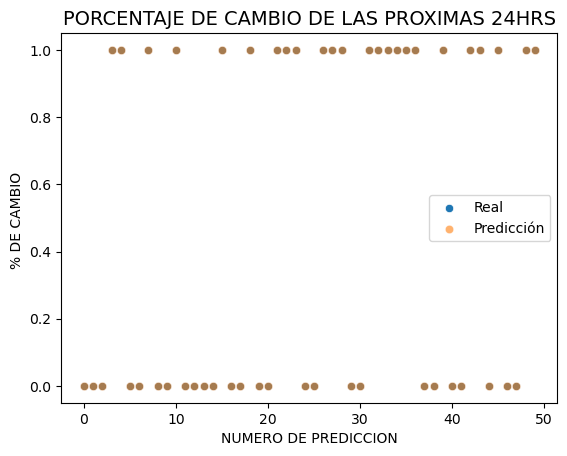

In [324]:
guardados=pd.DataFrame(columns=["real","predicciones","dif"])
guardados["real"]=y_real_guardadas
guardados["predicciones"]=y_pred_guardadas
plt.title("PORCENTAJE DE CAMBIO DE LAS PROXIMAS 24HRS", fontsize=14)
plt.ylabel("% DE CAMBIO ")
plt.xlabel("NUMERO DE PREDICCION")

sns.scatterplot(guardados,x=guardados.index,y=guardados["real"],label="Real")
sns.scatterplot(guardados,x=guardados.index,y="predicciones",label="Predicción",alpha=0.6)
plt.legend()

In [25]:
#hay que traducir a precio
#predio anterior-precio nuevo/precio anterior
#%*precioanterior--precioanterior
precios=[]
comparacion=pd.DataFrame(columns=["real","prediccion"])
rev=df_porcentual["close"].tail(len(guardados["predicciones"]))
rev.dropna(inplace=True)
rev.reset_index(drop=True,inplace=True)
for i in range(len(guardados["predicciones"])):
    precio=(rev[i])-((abs(guardados["predicciones"][i])/100)*(rev[i]))
    print(precio)
    precios.append(precio)
comparacion["real"]=rev
comparacion["prediccion"]=precios


108652.05649918457
108623.84035025992
108565.617978208
108556.61915596946
108688.21073022288
109213.56485095747
109385.47936513659
109269.53359773687
108546.74588996585
108354.1146542709


In [17]:
#crear DF completo y modelo  guardarlo todo para mañana 

import requests
import pandas as pd
import time
import joblib

cripto=[]
accuracy=[]
error_acertados=[]
e_total=[]
contador=0



binance_coins = [
    "ETHUSDT",  # Ethereum
    "BTCUSDT",  # Bitcoin  
    "BNBUSDT",  # Binance Coin
    "XRPUSDT",  # Ripple
    "SOLUSDT",  # Solana
    "ADAUSDT",  # Cardano
    "LTCUSDT",  # Litecoin
    "DOTUSDT",  # Polkadot
    "AVAXUSDT", # Avalanche
    "LINKUSDT", # Chainlink
]
# guardar en CSV
for simbolo in binance_coins:
    print(simbolo)
    df=get_binance_ohlcv(simbolo)
    
    porcentaje(df,"close",1,"1hora%")
    porcentaje(df,"close",4,"4hora%")
    porcentaje(df,"close",8,"8hora%")
    porcentaje(df,"close",24,"dia%")
    porcentaje(df,"close",48,"2dias%")
    porcentaje(df,"close",24*7,"1semana%")
    porcentaje(df,"close",24*7*2,"2semanas%")
    porcentaje(df,"close",24*7*4,"1mes%")
    


    df_porcentual=df
    calcular_RSI(df_porcentual)
    agregar_emas(df_porcentual)

    resistencias=volumen_por_precio(df_porcentual)
    df_porcentual["pred_dia%"]=df_porcentual["dia%"].shift(-24)
    #df.dropna(inplace=True)
    #df.reset_index(drop=True,inplace=True)
    print(len(df_porcentual))
    resis=[]
    df_porcentual["resistencia"]=0
    lista_redondeada_high = [round(x, 0) for x in list(df_porcentual["high"])]
    lista_redondeada_low = [round(x, 0) for x in list(df_porcentual["low"])]
    lista_redondeada_close = [round(x, 0) for x in list(df_porcentual["close"])]
    for i in list(round(resistencias["price_level"],0)):
        if i in lista_redondeada_high:

            indice=lista_redondeada_high.index(i)
            df_porcentual.loc[indice,"resistencia"]=1
        elif i in lista_redondeada_low:

            indice=lista_redondeada_low.index(i)
            df_porcentual.loc[indice,"resistencia"]=1
        elif i in lista_redondeada_close:

            indice=lista_redondeada_close.index(i)
            df_porcentual.loc[indice,"resistencia"]=1


    df_porcentual.dropna(inplace=True)
    df_porcentual.reset_index(drop=True,inplace=True)
    print(len(df_porcentual))
    df_porcentual.to_csv("/home/rodrigo/Escritorio/Repositorios/Proyecto_cripto_RH/data/raw/df_cripto/"+str(simbolo)+"_1h_250days_porcentual.csv", index=False)
    print("se tuvo que guardar")
    relativ_error=[]
    aciertos_direccion_list=[]
    error_aciertos_list=[]
    y_pred_guardadas=[]
    y_real_guardadas=[]
    restricciones=["open_time","pred_dia%"]
    medir="pred_dia%"
    print("empieza a modelo n: "+str(contador))
    filas=len(df_porcentual["close"])
    for i in range(120):
        if i%10==0:
            print(i)
        #vamos a separar los datos de entreno y los outsider
        entreno=df_porcentual[0+i:5183+i]
        outsider=df_porcentual[5183+i+1:5183+i+2]
        #print(outsider)
        outsider.reset_index(drop=True,inplace=True)
        entreno.reset_index(drop=True,inplace=True)
        #ahora ponemos el y el x
        X_entreno=entreno.drop(restricciones,axis=1)
        y=entreno[medir]
        X_train, X_test, y_train, y_test = train_test_split(X_entreno, y, test_size=0.001, random_state=42)
        model=RandomForestRegressor( n_estimators=50, random_state=42)
        model.fit(X_train,y_train)
        X_outsider=outsider.drop(restricciones,axis=1)
        y_outsider=outsider[medir]#es el real
        predicciones_outsider=model.predict(X_outsider)
        #print(y_outsider[0])
        y_pred_guardadas.append(predicciones_outsider[0])
        y_real_guardadas.append(y_outsider[0])
        error_relativo_porcentual=abs(y_outsider[0]-predicciones_outsider)/y_outsider[0]
        relativ_error.append(error_relativo_porcentual)
        if y_outsider[0]*predicciones_outsider>0:
            aciertos_direccion_list.append(predicciones_outsider)
            error_relativo_aciertos=abs(y_outsider[0]-predicciones_outsider)/y_outsider[0]
            error_aciertos_list.append(error_relativo_aciertos)

    error_total=abs(np.array(relativ_error).sum())/len(relativ_error)
    aciertos_direccion=len(aciertos_direccion_list)
    error_aciertos=abs(np.array(error_aciertos_list).sum())/len(error_aciertos_list)
    contador+=1
    
    cripto.append(simbolo)
    accuracy.append(aciertos_direccion/len(relativ_error))
    error_acertados.append(error_aciertos)
    e_total.append(error_total)
    print(accuracy)
    

# Supón que tu modelo se llama 'model'
    joblib.dump(model,"/home/rodrigo/Escritorio/Repositorios/Proyecto_cripto_RH/models/rand_forest_rf_"+str(simbolo)+".pkl")

ETHUSDT
6000
5304
se tuvo que guardar
empieza a modelo n: 0
0
10
20
30
40
50
60
70
80
90
100
110
[0.8083333333333333]
BTCUSDT
6000
5304
se tuvo que guardar
empieza a modelo n: 1
0
10
20
30
40
50
60
70
80
90
100
110
[0.8083333333333333, 0.8166666666666667]
BNBUSDT
6000
5304
se tuvo que guardar
empieza a modelo n: 2
0
10
20
30
40
50
60
70
80
90
100
110
[0.8083333333333333, 0.8166666666666667, 0.875]
XRPUSDT
6000
5304
se tuvo que guardar
empieza a modelo n: 3
0
10
20
30
40
50
60
70
80
90
100
110
[0.8083333333333333, 0.8166666666666667, 0.875, 0.85]
SOLUSDT
6000
5304
se tuvo que guardar
empieza a modelo n: 4
0
10
20
30
40
50
60
70
80
90
100
110
[0.8083333333333333, 0.8166666666666667, 0.875, 0.85, 0.85]
ADAUSDT
6000
5304
se tuvo que guardar
empieza a modelo n: 5
0
10
20
30
40
50
60
70
80
90
100
110
[0.8083333333333333, 0.8166666666666667, 0.875, 0.85, 0.85, 0.8]
LTCUSDT
6000
5304
se tuvo que guardar
empieza a modelo n: 6
0
10
20
30
40
50
60
70
80
90
100
110
[0.8083333333333333, 0.816666666

KeyboardInterrupt: 

In [ ]:
binance_coins = [
    "ETHUSDT"
    ,"BTCUSDT",  # Bitcoin  # Ethereum
    "BNBUSDT",  # Binance Coin
    "XRPUSDT",  # Ripple
    "SOLUSDT",  # Solana
    "DOGEUSDT", # Dogecoin
    "ADAUSDT",  # Cardano
    "LTCUSDT",  # Litecoin
    "DOTUSDT",  # Polkadot
    "MATICUSDT",# Polygon
    "AVAXUSDT", # Avalanche
    "LINKUSDT", # Chainlink
    "TRXUSDT",  # Tron
    "ATOMUSDT", # Cosmos
    "SHIBUSDT", # Shiba Inu
    "WBTCUSDT", # Wrapped Bitcoin
    "BUSDUSDT", # Binance USD (stablecoin)
    "XLMUSDT"   # Stellar
]



In [485]:
from scipy.signal import find_peaks
def detectar_resistencias_por_picos(df, col_close='close', distancia=120, tolerancia=0.002):
    precios = df[col_close].values
    # find_peaks busca picos locales (máximos)
    indices, _ = find_peaks(precios, distance=distancia)

    resistencias = []

    for i in indices:
        precio_pico = precios[i]

        # Contamos cuántas veces el precio tocó esa zona ± tolerancia
        test_count = np.sum(
            np.abs(precios - precio_pico) / precio_pico < tolerancia
        )

        # Clasificamos la fuerza
        if test_count >= 5:
            fuerza = "fuerte"
        elif test_count >= 3:
            fuerza = "media"
        else:
            fuerza = "debil"

        resistencias.append({"precio": precio_pico, "fuerza": fuerza})

    resistencias_df = pd.DataFrame(resistencias).drop_duplicates(subset="precio").sort_values("precio")
    return resistencias_df.reset_index(drop=True)
res=detectar_resistencias_por_picos(df_porcentual)
res

,precio,fuerza
0,157.79,media
1,247.73,media
2,285.15,debil
3,339.39,debil
4,475.40,media
5,729.08,media
6,1276.00,fuerte
7,1320.69,fuerte
8,1388.02,debil
9,1795.07,fuerte


In [487]:
def detectar_resistencias_por_picos(df, col_close='close', distancia=45, tolerancia=0.002):
    """
    Detecta picos locales (máximos) y clasifica fuerza según cuántas veces se testearon.
    distancia: min número de muestras entre picos (reduce detección de picos muy cercanos)
    tolerancia: % relativo para contar "toques" alrededor del pico (ej 0.002 = 0.2%)
    """
    # Asegurarnos que la columna es numérica y sin NaNs temporales
    precios = pd.to_numeric(df[col_close], errors='coerce').fillna(method='ffill').values.astype(float)

    # find_peaks devuelve índices de máximos locales
    indices, _ = find_peaks(precios, distance=distancia)

    resistencias = []
    for i in indices:
        precio_pico = float(precios[i])

        # contar cuántas veces el precio estuvo dentro de ±tolerancia relativa
        test_count = np.sum(np.abs(precios - precio_pico) / precio_pico < tolerancia)

        # clasificar fuerza por cantidad de toques (ajusta umbrales si quieres)
        if test_count >= 5:
            fuerza = "fuerte"
        elif test_count >= 3:
            fuerza = "media"
        else:
            fuerza = "debil"

        resistencias.append({"precio": precio_pico, "fuerza": fuerza, "toques": int(test_count)})

    res_df = pd.DataFrame(resistencias).drop_duplicates(subset="precio").sort_values("precio").reset_index(drop=True)
    return res_df


def asignar_resistencia(df, resistencias, col_close='close'):
    """
    Para cada fila de df:
      - asigna la resistencia MÁS CERCANA POR ENCIMA (si existe)
      - calcula distancia relativa en % (res - precio)/precio * 100
      - deja fuerza de la resistencia
    Maneja correctamente casos sin resistencia (produce NaN).
    """
    # Asegurarse tipos
    precios_res = resistencias['precio'].values.astype(float) if not resistencias.empty else np.array([], dtype=float)
    fuerzas_res = resistencias['fuerza'].values if not resistencias.empty else np.array([], dtype=object)

    resistencia_cercana = []
    distancia_res_pct = []
    fuerza_resistencia = []

    for p_raw in df[col_close].values:
        # si el precio es NaN, devolver NaNs
        try:
            p = float(p_raw)
        except Exception:
            resistencia_cercana.append(np.nan)
            distancia_res_pct.append(np.nan)
            fuerza_resistencia.append(None)
            continue

        if precios_res.size == 0:
            resistencia_cercana.append(np.nan)
            distancia_res_pct.append(np.nan)
            fuerza_resistencia.append(None)
            continue

        # elegir solo resistencias por encima del precio actual
        superiores = precios_res[precios_res > p]
        if superiores.size == 0:
            # no hay resistencia por encima
            resistencia_cercana.append(np.nan)
            distancia_res_pct.append(np.nan)
            fuerza_resistencia.append(None)
            continue

        # resistencia más cercana por encima
        res_mas_cercana = float(superiores.min())
        # índice robusto (en caso de problemas de float equality)
        idx = int(np.argmin(np.abs(precios_res - res_mas_cercana)))

        fuerza = fuerzas_res[idx]
        distancia = (res_mas_cercana - p) / p * 100.0  # en porcentaje

        resistencia_cercana.append(res_mas_cercana)
        distancia_res_pct.append(distancia)
        fuerza_resistencia.append(fuerza)

    # Asignar columnas al df sin romper por None
    df = df.copy()
    df['resistencia_precio'] = pd.Series(resistencia_cercana, index=df.index).astype(float)
    df['distancia_resistencia_%_media'] = pd.Series(distancia_res_pct, index=df.index).astype(float).round(3)
    df['fuerza_resistencia_media'] = pd.Series(fuerza_resistencia, index=df.index).astype(object)

    return df
res = detectar_resistencias_por_picos(df_porcentual, col_close='close', distancia=45, tolerancia=0.005)
df_porcentual = asignar_resistencia(df_porcentual.reset_index(), res, col_close='close')

/tmp/ipykernel_6159/3058702461.py:8: FutureWarning:

Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.



In [489]:
df_porcentual["fuerza_resistencia_media"]=df_porcentual["fuerza_resistencia_media"].factorize()[0]

In [298]:
df_porcentual

,level_0,index,open_time,open,high,low,close,volume,number_of_trades,1dia%,...,EMA_200,resistencia,resistencia_precio,distancia_resistencia_%,distancia_resistencia_%_grande,fuerza_resistencia_grande,distancia_resistencia_%_media,fuerza_resistencia_media,distancia_resistencia_%_chica,fuerza_resistencia_chica
0,0,0,2017-09-17,3685.23,3748.21,3499.02,3699.99,682.171210,6355,0.402697,...,3714.801144,0,4117.76,11.291,11.291,0,11.291,0,11.291,0
1,1,1,2017-09-18,3690.00,4123.20,3690.00,4035.01,1030.006455,8220,-9.054619,...,3717.987302,0,4117.76,2.051,2.051,0,2.051,0,2.051,0
2,2,2,2017-09-19,4060.00,4089.97,3830.91,3910.04,902.332129,7342,3.097142,...,3719.898274,0,4117.76,5.312,5.312,0,5.312,0,5.312,0
3,3,3,2017-09-20,3910.04,4046.08,3820.00,3900.00,720.935076,7231,0.256775,...,3721.690331,0,4117.76,5.584,5.584,0,5.584,0,5.584,0
4,4,4,2017-09-21,3889.99,3910.00,3567.00,3609.99,1001.654084,8714,7.436154,...,3720.578885,0,4117.76,14.066,14.066,0,14.066,0,14.066,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2934,2934,2934,2025-09-29,112163.96,114400.00,111560.65,114311.96,15541.120050,2442653,-1.915063,...,106338.818702,0,123306.43,7.868,7.868,2,7.868,2,7.868,2
2935,2935,2935,2025-09-30,114311.97,114792.00,112656.27,114048.93,15044.156330,3018331,0.230098,...,106415.536228,0,114311.96,8.117,8.117,2,0.231,2,8.117,2
2936,2936,2936,2025-10-01,114048.94,118649.10,113966.67,118594.99,20036.395160,3430343,-3.986061,...,106536.724822,0,123306.43,3.973,3.973,2,3.973,2,3.973,2
2937,2937,2937,2025-10-02,118594.99,121022.07,118279.31,120529.35,19670.835030,3472073,-1.631064,...,106675.954924,0,123306.43,2.304,2.304,2,2.304,2,2.304,2


# XGBoots #

In [333]:
from xgboost import XGBRegressor,XGBClassifier
from sklearn.model_selection import GridSearchCV

In [490]:
df_porcentual

,level_0,index,open,high,low,close,volume,number_of_trades,1dia%,2dias%,...,RSI,EMA_9,EMA_21,EMA_50,EMA_100,EMA_200,resistencia,resistencia_precio,distancia_resistencia_%_media,fuerza_resistencia_media
0,0,0,255.99,271.81,235.51,249.31,10362.06011,8859.0,1.458498,-15.844989,...,35.771216,272.733502,296.323595,306.495084,306.686866,305.146747,0.0,285.15,14.376,0
1,1,1,249.32,264.39,239.02,257.55,4614.53337,5277.0,-3.305122,-1.798419,...,38.562048,269.696802,292.798723,304.575669,305.713858,304.673148,0.0,285.15,10.716,0
2,2,2,257.53,306.22,257.11,294.57,4125.97051,3440.0,-14.373908,-18.154105,...,49.422814,274.671442,292.959748,304.183290,305.493188,304.572619,0.0,311.07,5.601,0
3,3,3,296.00,300.00,277.41,284.00,1869.90852,1896.0,3.588281,-10.269851,...,46.823159,276.537153,292.145226,303.391788,305.067580,304.367916,0.0,285.15,0.405,0
4,4,4,284.01,294.00,275.91,282.00,1060.56734,1431.0,0.704225,4.267237,...,46.316089,277.629723,291.222932,302.552894,304.610796,304.145350,0.0,285.15,1.117,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2936,2936,2936,4215.07,4245.00,4092.10,4145.15,391126.61720,4118784.0,1.658810,-0.072185,...,43.665976,4166.637197,4259.671644,4210.449760,3871.544893,3425.192696,0.0,4173.45,0.683,0
2937,2937,2937,4145.15,4355.46,4123.08,4348.03,507026.38220,4138481.0,-4.894395,-3.154396,...,53.991254,4202.915757,4267.704222,4215.845064,3880.980242,3434.375157,0.0,4807.98,10.578,2
2938,2938,2938,4348.03,4516.74,4332.73,4484.35,526411.15710,4441183.0,-3.135213,-8.183057,...,59.480449,4259.202606,4287.399292,4226.374669,3892.928158,3444.822668,0.0,4807.98,7.217,2
2939,2939,2939,4484.35,4591.59,4428.00,4512.87,485684.02670,5149648.0,-0.635990,-3.791142,...,60.563258,4309.936085,4307.896629,4237.609780,3905.204234,3455.450004,0.0,4807.98,6.539,2


52.2

In [518]:
df_porcentual.columns

Index(['level_0', 'index', 'open', 'high', 'low', 'close', 'volume',
       'number_of_trades', '1dia%', '2dias%', '1semana%', '2semanas%', '1mes%',
       'pred_dia%', 'RSI', 'EMA_9', 'EMA_21', 'EMA_50', 'EMA_100', 'EMA_200',
       'resistencia', 'resistencia_precio', 'distancia_resistencia_%_media',
       'fuerza_resistencia_media', 'direccion_pred', 'macd', 'signal_line',
       'histograma', 'señal'],
      dtype='object')

In [525]:
corr_direccion=0
relativ_error=[]
aciertos_direccion_list=[]
error_aciertos_list=[]
y_pred_guardadas=[]
y_real_guardadas=[]
restricciones=['level_0', 'index', 'open', 'high', 'low', 'close', 'volume',
       'number_of_trades', '1dia%', '2dias%', '1semana%', '2semanas%', '1mes%',
       'pred_dia%', 'RSI', 'EMA_9', 'EMA_21', 'EMA_50', 'EMA_100', 'EMA_200',
       'resistencia', 'resistencia_precio', 'distancia_resistencia_%_media',
       'fuerza_resistencia_media', 'direccion_pred',  'signal_line',
       'histograma']
##'low', 'close', 'volume', '1dia%', '2dias%', '1semana%', '1mes%', 'RSI', 'EMA_9', 'EMA_50', 'EMA_200', 'fuerza_resistencia_media']
#🏆 Mejor configuración encontrada:
#{'n_estimators': 1059, 'max_depth': 3, 'learning_rate': 0.011887026096974496, 'subsample': 0.865440715748136, 'colsample_bytree': 0.7939766762915174, 'min_child_weight': 2, 'gamma': 2.742196384943722, 'reg_lambda': 4.585539908766492, 'reg_alpha': 0.8738629423471196, 'use_open': False, 'use_high': False, 'use_low': True, 'use_close': False, 'use_volume': True, 'use_1dia%': True, 'use_2dias%': False, 'use_1semana%': True, 'use_2semanas%': False, 'use_1mes%': True, 'use_RSI': True, 'use_EMA_9': False, 'use_EMA_21': True, 'use_EMA_50': False, 'use_EMA_100': False, 'use_EMA_200': False, 'use_distancia_resistencia_%': False, 'use_fuerza_resistencia_media': True}

#📊 Features seleccionadas:
#['low', 'volume', '1dia%', '1semana%', '1mes%', 'RSI', 'EMA_21', 'fuerza_resistencia_media']
medir='direccion_pred'
for i in range(100):
    print(i)
    #vamos a separar los datos de entreno y los outsider
    entreno=df_porcentual[0+i:2838+i]
    outsider=df_porcentual[2838+i+2:2838+i+3]
    #print(outsider)
    outsider.reset_index(drop=True,inplace=True)
    entreno.reset_index(drop=True,inplace=True)
    #ahora ponemos el y el x
    X_entreno=entreno.drop(restricciones,axis=1)
    y=entreno[medir]
    X_train, X_test, y_train, y_test = train_test_split(X_entreno, y, test_size=0.2, random_state=42)
    #model=XGBRegressor(random_state=42,colsample_bytree=1, gamma= 0.5, learning_rate= 0.05 ,min_child_weight= 10, n_estimators= 500, reg_alpha= 0.01, reg_lambda= 0.5, subsample= 0.8)
    model=XGBClassifier(n_estimators= 1056, max_depth= 1, learning_rate= 0.011887026096974496, subsample= 0.865440715748136, colsample_bytree= 0.72, min_child_weight= 3, gamma= 2.677408648496625,reg_lambda= 3.8577729312701874, reg_alpha= 0.9,random_state=42)
    model.fit(X_train,y_train)
    X_outsider=outsider.drop(restricciones,axis=1)
    y_outsider=outsider[medir]#es el real
    predicciones_outsider=model.predict(X_outsider)
    #print(y_outsider[0])
    y_pred_guardadas.append(predicciones_outsider[0])
    y_real_guardadas.append(y_outsider[0])

    
    if predicciones_outsider[0]==y_outsider[0]:
        corr_direccion+=1
print(corr_direccion/100)


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
0.58


la configuracion logra un 61% en BTC



['level_0', 'index',  'pred_dia%' , 'direccion_pred','open', 'high', 
        'number_of_trades',  '2dias%', 
       '2semanas%', 'pred_dia%',    'EMA_50',
       'EMA_100', 'EMA_200', 'resistencia', 'resistencia_precio',
       'distancia_resistencia_%', 'distancia_resistencia_%_grande',
       'fuerza_resistencia_grande', 'distancia_resistencia_%_media',
        'distancia_resistencia_%_chica',
       'fuerza_resistencia_chica']

In [506]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt

def calcular_macd(datos, short_window=12, long_window=26, signal_window=9):
    """
    Calcula el MACD, la línea de señal y el histograma.

    Args:
        datos (pd.Series): Serie de pandas con los precios de cierre.
        short_window (int): Período para la EMA corta (por defecto 12).
        long_window (int): Período para la EMA larga (por defecto 26).
        signal_window (int): Período para la EMA de la señal (por defecto 9).

    Returns:
        pd.DataFrame: Un DataFrame con las columnas 'MACD', 'Signal_Line' e 'Histogram'.
    """
    # 1. Calcular la Media Móvil Exponencial (EMA) corta y larga
    ema_corta = datos.ewm(span=short_window, adjust=False).mean()
    ema_larga = datos.ewm(span=long_window, adjust=False).mean()

    # 2. Calcular la línea MACD
    macd_line = ema_corta - ema_larga

    # 3. Calcular la línea de Señal
    signal_line = macd_line.ewm(span=signal_window, adjust=False).mean()

    # 4. Calcular el Histograma
    histograma = macd_line - signal_line

    # Crear un DataFrame con los resultados
    df_macd = pd.DataFrame({
        'MACD': macd_line,
        'Signal_Line': signal_line,
        'Histogram': histograma
    })

    return df_macd
calcular_macd(df_porcentual["close"])

,MACD,Signal_Line,Histogram
0,0.000000,0.000000,0.000000
1,0.657322,0.131464,0.525858
2,4.117989,0.928769,3.189220
3,5.939219,1.930859,4.008360
4,7.138881,2.972464,4.166417
...,...,...,...
2936,-78.053942,-49.170820,-28.883122
2937,-60.185516,-51.373759,-8.811757
2938,-34.625632,-48.024134,13.398502
2939,-11.930388,-40.805384,28.874996


In [513]:

import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def calcular_macd(datos, short_window=12, long_window=26, signal_window=9):
    """Calcula el MACD, la línea de señal y el histograma."""
    ema_corta = datos.ewm(span=short_window, adjust=False).mean()
    ema_larga = datos.ewm(span=long_window, adjust=False).mean()
    macd_line = ema_corta - ema_larga
    signal_line = macd_line.ewm(span=signal_window, adjust=False).mean()
    
    df_macd = pd.DataFrame({
        'MACD': macd_line,
        'Signal_Line': signal_line
    })
    return df_macd

def generar_senales_macd(df):
    """
    Genera señales de compra (1) y venta (0) basadas en el cruce de MACD.
    """
    # Se crea una copia para evitar advertencias de SettingWithCopyWarning
    data = df.copy()
    
    # Condición de compra: MACD cruza por encima de la Signal Line
    # Comparamos el valor actual con el del día anterior usando .shift(1)
    condicion_compra = (data['MACD'] > data['Signal_Line']) & (data['MACD'].shift(1) <= data['Signal_Line'].shift(1))

    # Condición de venta: MACD cruza por debajo de la Signal Line
    condicion_venta = (data['MACD'] < data['Signal_Line']) & (data['MACD'].shift(1) >= data['Signal_Line'].shift(1))

    # Asignamos 1 para compra, 0 para venta
    # Usamos np.nan para los días sin señal
    data['Señal'] = np.nan
    data.loc[condicion_compra, 'Señal'] = 1
    data.loc[condicion_venta, 'Señal'] = 0
    
    return data
df_macd = calcular_macd(df_porcentual['close'])
df_macd_con_senales = generar_senales_macd(df_macd)
df_macd_con_senales

,MACD,Signal_Line,Señal
0,0.000000,0.000000,NaN
1,0.657322,0.131464,1.0
2,4.117989,0.928769,NaN
3,5.939219,1.930859,NaN
4,7.138881,2.972464,NaN
...,...,...,...
2936,-78.053942,-49.170820,NaN
2937,-60.185516,-51.373759,NaN
2938,-34.625632,-48.024134,1.0
2939,-11.930388,-40.805384,NaN


In [515]:
df_porcentual

,level_0,index,open,high,low,close,volume,number_of_trades,1dia%,2dias%,...,EMA_200,resistencia,resistencia_precio,distancia_resistencia_%_media,fuerza_resistencia_media,direccion_pred,macd,signal_line,histograma,señal
0,0,0,255.99,271.81,235.51,249.31,10362.06011,8859.0,1.458498,-15.844989,...,305.146747,0.0,285.15,14.376,0,0,0.000000,0.000000,0.000000,NaN
1,1,1,249.32,264.39,239.02,257.55,4614.53337,5277.0,-3.305122,-1.798419,...,304.673148,0.0,285.15,10.716,0,0,0.657322,0.131464,0.525858,1.0
2,2,2,257.53,306.22,257.11,294.57,4125.97051,3440.0,-14.373908,-18.154105,...,304.572619,0.0,311.07,5.601,0,1,4.117989,0.928769,3.189220,NaN
3,3,3,296.00,300.00,277.41,284.00,1869.90852,1896.0,3.588281,-10.269851,...,304.367916,0.0,285.15,0.405,0,1,5.939219,1.930859,4.008360,NaN
4,4,4,284.01,294.00,275.91,282.00,1060.56734,1431.0,0.704225,4.267237,...,304.145350,0.0,285.15,1.117,0,1,7.138881,2.972464,4.166417,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2936,2936,2936,4215.07,4245.00,4092.10,4145.15,391126.61720,4118784.0,1.658810,-0.072185,...,3425.192696,0.0,4173.45,0.683,0,0,-78.053942,-49.170820,-28.883122,NaN
2937,2937,2937,4145.15,4355.46,4123.08,4348.03,507026.38220,4138481.0,-4.894395,-3.154396,...,3434.375157,0.0,4807.98,10.578,2,0,-60.185516,-51.373759,-8.811757,NaN
2938,2938,2938,4348.03,4516.74,4332.73,4484.35,526411.15710,4441183.0,-3.135213,-8.183057,...,3444.822668,0.0,4807.98,7.217,2,0,-34.625632,-48.024134,13.398502,1.0
2939,2939,2939,4484.35,4591.59,4428.00,4512.87,485684.02670,5149648.0,-0.635990,-3.791142,...,3455.450004,0.0,4807.98,6.539,2,1,-11.930388,-40.805384,28.874996,NaN


In [514]:
df_porcentual["señal"]=df_macd_con_senales["Señal"].values

In [507]:
df_porcentual["macd"]=calcular_macd(df_porcentual["close"])["MACD"]
df_porcentual["signal_line"]=calcular_macd(df_porcentual["close"])["Signal_Line"]
df_porcentual["histograma"]=calcular_macd(df_porcentual["close"])["Histogram"]

In [430]:
import optuna
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import TimeSeriesSplit, cross_val_score
import numpy as np

# -----------------------------
# 1️⃣ Lista de features posibles
# -----------------------------
all_features = [
    'high', 'low', 'close',
       'volume', 'number_of_trades', '1dia%', '2dias%', '1semana%',
       '2semanas%', '1mes%', 'RSI', 'EMA_9', 'EMA_21', 'EMA_50',
       'EMA_100', 'EMA_200', 'resistencia', 'resistencia_precio',
       'distancia_resistencia_%', 'distancia_resistencia_%_grande',
       'fuerza_resistencia_grande', 'distancia_resistencia_%_media',
       'fuerza_resistencia_media', 'distancia_resistencia_%_chica',
       'fuerza_resistencia_chica'
]

# -----------------------------
# 2️⃣ Función objetivo para Optuna
# -----------------------------
def objective(trial):
    # 🔹 RandomForest hiperparámetros
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 300, 1200),
        "max_depth": trial.suggest_int("max_depth", 3, 15),
        "min_samples_split": trial.suggest_int("min_samples_split", 2, 10),
        "min_samples_leaf": trial.suggest_int("min_samples_leaf", 1, 5),
        "max_features": trial.suggest_categorical("max_features", ["sqrt", "log2", None]),
        "class_weight": "balanced",
        "random_state": 42,
        "n_jobs": -1
    }

    # 🔹 Selección de features
    selected_features = [f for f in all_features if trial.suggest_categorical(f"use_{f}", [True, False])]

    # Si no selecciona ninguna, usar al menos close + volume
    if len(selected_features) == 0:
        selected_features = ["close", "volume"]

    X_sub = X_train[selected_features]

    tscv = TimeSeriesSplit(n_splits=5)
    model = RandomForestClassifier(**params)
    scores = cross_val_score(model, X_sub, y_train, cv=tscv, scoring="roc_auc", n_jobs=-1)

    return np.mean(scores)

# -----------------------------
# 3️⃣ Crear y ejecutar estudio
# -----------------------------
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=300)  # puedes aumentar si tienes tiempo o GPU

# -----------------------------
# 4️⃣ Resultados
# -----------------------------
print("🏆 Mejor configuración encontrada:")
print(study.best_params)

selected_features = [f for f in all_features if study.best_params.get(f"use_" + f, False)]
print("\n📊 Features seleccionadas por Optuna:")
print(selected_features)

[I 2025-10-04 23:17:59,128] A new study created in memory with name: no-name-33944ac3-0b18-49b6-bca1-49dd13454a9f
[I 2025-10-04 23:18:04,163] Trial 0 finished with value: 0.5101635481477375 and parameters: {'n_estimators': 636, 'max_depth': 14, 'min_samples_split': 3, 'min_samples_leaf': 2, 'max_features': None, 'use_high': True, 'use_low': False, 'use_close': True, 'use_volume': True, 'use_number_of_trades': False, 'use_1dia%': True, 'use_2dias%': False, 'use_1semana%': False, 'use_2semanas%': True, 'use_1mes%': False, 'use_RSI': True, 'use_EMA_9': False, 'use_EMA_21': True, 'use_EMA_50': True, 'use_EMA_100': False, 'use_EMA_200': True, 'use_resistencia': True, 'use_resistencia_precio': True, 'use_distancia_resistencia_%': True, 'use_distancia_resistencia_%_grande': True, 'use_fuerza_resistencia_grande': True, 'use_distancia_resistencia_%_media': True, 'use_fuerza_resistencia_media': False, 'use_distancia_resistencia_%_chica': False, 'use_fuerza_resistencia_chica': False}. Best is tri

🏆 Mejor configuración encontrada:
{'n_estimators': 1183, 'max_depth': 11, 'min_samples_split': 6, 'min_samples_leaf': 3, 'max_features': 'log2', 'use_high': False, 'use_low': False, 'use_close': False, 'use_volume': False, 'use_number_of_trades': True, 'use_1dia%': True, 'use_2dias%': False, 'use_1semana%': False, 'use_2semanas%': False, 'use_1mes%': False, 'use_RSI': False, 'use_EMA_9': False, 'use_EMA_21': False, 'use_EMA_50': False, 'use_EMA_100': False, 'use_EMA_200': False, 'use_resistencia': True, 'use_resistencia_precio': False, 'use_distancia_resistencia_%': False, 'use_distancia_resistencia_%_grande': False, 'use_fuerza_resistencia_grande': True, 'use_distancia_resistencia_%_media': True, 'use_fuerza_resistencia_media': False, 'use_distancia_resistencia_%_chica': False, 'use_fuerza_resistencia_chica': False}

📊 Features seleccionadas por Optuna:
['number_of_trades', '1dia%', 'resistencia', 'fuerza_resistencia_grande', 'distancia_resistencia_%_media']


In [432]:
import optuna
from xgboost import XGBClassifier
from sklearn.model_selection import TimeSeriesSplit, cross_val_score
import numpy as np

# 🔹 Lista de todas las features posibles que tienes en tu dataset
all_features = [
    'open', 'high', 'low', 'close', 'volume',
    '1dia%', '2dias%', '1semana%', '2semanas%', '1mes%',
    'RSI', 'EMA_9', 'EMA_21', 'EMA_50', 'EMA_100', 'EMA_200',
    'distancia_resistencia_%', 'fuerza_resistencia_media'
]

def objective(trial):
    # 🔸 El modelo que vamos a optimizar
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 300, 1200),
        "max_depth": trial.suggest_int("max_depth", 3, 10),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3, log=True),
        "subsample": trial.suggest_float("subsample", 0.6, 0.9),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 0.9),
        "min_child_weight": trial.suggest_int("min_child_weight", 1, 8),
        "gamma": trial.suggest_float("gamma", 0, 3),
        "reg_lambda": trial.suggest_float("reg_lambda", 0.5, 5.0),
        "reg_alpha": trial.suggest_float("reg_alpha", 0, 1.0),
        "tree_method": "hist",
        "eval_metric": "auc",
        "random_state": 42
    }

    # 🔹 Aquí Optuna decide si usa cada feature o no (True/False)
    selected_features = [
        f for f in all_features if trial.suggest_categorical(f"use_{f}", [True, False])
    ]

    # Si por casualidad no elige ninguna, usa al menos algo
    if len(selected_features) == 0:
        selected_features = ["close", "volume"]

    X_sub = X_train[selected_features]

    tscv = TimeSeriesSplit(n_splits=5)
    model = XGBClassifier(**params)
    scores = cross_val_score(model, X_sub, y_train, cv=tscv, scoring="roc_auc", n_jobs=-1)

    return np.mean(scores)


# 🔸 Crear el estudio de búsqueda
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=600)  # puedes subir a 200 si tienes GPU o tiempo

# 🔹 Resultados
print("🏆 Mejor configuración encontrada:")
print(study.best_params)

# 🔹 Qué features eligió finalmente
selected_features = [f for f in all_features if study.best_params.get(f"use_" + f, False)]
print("\n📊 Features seleccionadas:")
print(selected_features)


[I 2025-10-04 23:29:38,095] A new study created in memory with name: no-name-5ea67a35-e02d-4306-b1ee-d48bfa933134
[I 2025-10-04 23:29:38,494] Trial 0 finished with value: 0.505345205933122 and parameters: {'n_estimators': 1155, 'max_depth': 7, 'learning_rate': 0.09185448312172444, 'subsample': 0.792280895481936, 'colsample_bytree': 0.8635859923814788, 'min_child_weight': 7, 'gamma': 0.6279935337987647, 'reg_lambda': 2.658717448226937, 'reg_alpha': 0.19392967516271942, 'use_open': False, 'use_high': True, 'use_low': True, 'use_close': False, 'use_volume': False, 'use_1dia%': True, 'use_2dias%': True, 'use_1semana%': True, 'use_2semanas%': False, 'use_1mes%': True, 'use_RSI': False, 'use_EMA_9': True, 'use_EMA_21': True, 'use_EMA_50': False, 'use_EMA_100': True, 'use_EMA_200': False, 'use_distancia_resistencia_%': True, 'use_fuerza_resistencia_media': True}. Best is trial 0 with value: 0.505345205933122.
[I 2025-10-04 23:29:38,613] Trial 1 finished with value: 0.5004668583444993 and para

🏆 Mejor configuración encontrada:
{'n_estimators': 1059, 'max_depth': 3, 'learning_rate': 0.011887026096974496, 'subsample': 0.865440715748136, 'colsample_bytree': 0.7939766762915174, 'min_child_weight': 2, 'gamma': 2.742196384943722, 'reg_lambda': 4.585539908766492, 'reg_alpha': 0.8738629423471196, 'use_open': False, 'use_high': False, 'use_low': True, 'use_close': False, 'use_volume': True, 'use_1dia%': True, 'use_2dias%': False, 'use_1semana%': True, 'use_2semanas%': False, 'use_1mes%': True, 'use_RSI': True, 'use_EMA_9': False, 'use_EMA_21': True, 'use_EMA_50': False, 'use_EMA_100': False, 'use_EMA_200': False, 'use_distancia_resistencia_%': False, 'use_fuerza_resistencia_media': True}

📊 Features seleccionadas:
['low', 'volume', '1dia%', '1semana%', '1mes%', 'RSI', 'EMA_21', 'fuerza_resistencia_media']


In [348]:
tabla_resultados=pd.DataFrame(columns=["error_total","error_aciertos","aciertos_direccion"])
tabla_resultados["error_total"]=error_total
tabla_resultados["error_aciertos"]=error_aciertos
tabla_resultados["aciertos_direccion"]=aciertos_direccion
print(f'error_aciertos: {error_aciertos}')
print(f'n_aciertos: {aciertos_direccion/len(relativ_error)}')
print(f'error total: {error_total}')


error_aciertos: 0.0


ZeroDivisionError: division by zero

<Axes: xlabel='None', ylabel='real'>

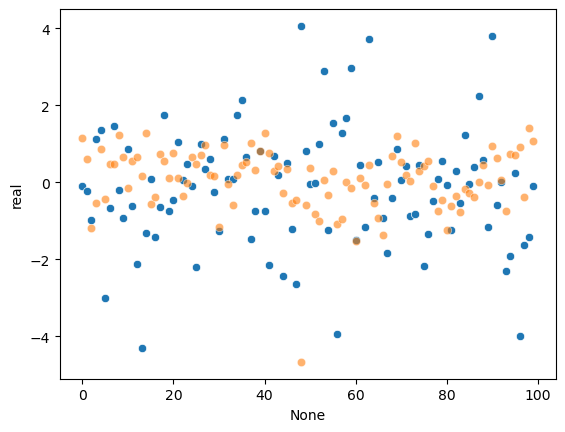

In [309]:
guardados=pd.DataFrame(columns=["real","predicciones","dif"])
guardados["real"]=y_real_guardadas
guardados["predicciones"]=y_pred_guardadas
sns.scatterplot(guardados,x=guardados.index,y=guardados["real"])
sns.scatterplot(guardados,x=guardados.index,y="predicciones",alpha=0.6)

In [495]:
df_porcentual["direccion_pred"]=0
for i in range(len(df_porcentual["close"])):
    if df_porcentual["pred_dia%"][i]>0:
        df_porcentual.loc[i,"direccion_pred"]=1
    else:
        df_porcentual.loc[i,"direccion_pred"]=0
     

In [313]:
df_porcentual["pred_dia%"]

0      -9.054619
1       3.097142
2       0.256775
3       7.436154
4       0.391137
          ...   
2934    0.230098
2935   -3.986061
2936   -1.631064
2937   -1.412643
2938   -0.091367
Name: pred_dia%, Length: 2939, dtype: float64

In [105]:
def detectar_zonas_bajo_volumen(df, bins=80, n_zonas=150):
    """
    Calcula las zonas de bajo volumen (LVN) a partir de un perfil de volumen simple.

    bins: número de niveles de precios en el histograma
    n_zonas: cantidad de zonas de bajo volumen que quieres identificar
    """
    # Tomamos precio medio de cada vela
    df["precio_medio"] = (df["high"] + df["low"]) / 2
    precios = df["precio_medio"]
    volumenes = df["volume"]

    # Construir histograma ponderado por volumen
    hist, edges = np.histogram(precios, bins=bins, weights=volumenes)

    # Normalizamos
    hist = hist / hist.max()

    # Detectar los índices de menor volumen
    indices_lv = np.argsort(hist)[:n_zonas]
    zonas_bajo_volumen = [(edges[i], edges[i+1], hist[i]) for i in indices_lv]
   
    return zonas_bajo_volumen, hist, edges
zbv=detectar_zonas_bajo_volumen(df_porcentual)


In [106]:
#zonas de bajo volumen
df_porcentual["bajo_volumen"]=0
for i in zbv[0]:
    down=list(df_porcentual["close"].round(-3)).index(round(float(i[0]),-3))
    up=list(df_porcentual["close"].round(-3)).index(round(float(i[1]),-3))
    for o in range(1000):
        if df_porcentual["close"][o]==o:
            break
        elif df_porcentual["close"][o]!=o:
            df_porcentual.loc[o,"bajo_volumen"]=1

            






ValueError: 74000.0 is not in list

In [ ]:
#agregar las zonas de bajo volumen
for i in zbv[0]:
    for o in i:
        print(o)

368.34175000000005
371.57087500000006
0.0
365.1126250000001
368.34175000000005
0.0
342.5087500000001
345.73787500000003
0.021427931892905067
339.279625
342.5087500000001
0.02576023878280346
355.42525000000006
358.6543750000001
0.03869081730676724
361.8835
365.1126250000001
0.04046366988838033
119.699125
122.92825
0.055616995295260756
336.05050000000006
339.279625
0.06277751075950701
371.57087500000006
374.8
0.06433110183897132
358.6543750000001
361.8835
0.07327003818001582
345.73787500000003
348.96700000000004
0.08829675771830653
352.19612500000005
355.42525000000006
0.08864454585151317
348.96700000000004
352.19612500000005
0.11393790044654274
116.47
119.699125
0.1258172223606787
332.82137500000005
336.05050000000006
0.12996095364524937
155.2195
158.448625
0.13675905731590166
122.92825
126.157375
0.1494916480194506
151.990375
155.2195
0.15606293327294016
126.157375
129.3865
0.17280733975357737
239.17675000000003
242.40587500000004
0.1926511798808756
145.532125
148.76125000000002
0.2184

In [ ]:
import requests

url = "https://api.binance.com/api/v3/exchangeInfo"
data = requests.get(url).json()

# Extraer todos los símbolos disponibles
symbols = [s['symbol'] for s in data['symbols']]
print(symbols[:20])  # mostrar los primeros 20

['ETHBTC', 'LTCBTC', 'BNBBTC', 'NEOBTC', 'QTUMETH', 'EOSETH', 'SNTETH', 'BNTETH', 'BCCBTC', 'GASBTC', 'BNBETH', 'BTCUSDT', 'ETHUSDT', 'HSRBTC', 'OAXETH', 'DNTETH', 'MCOETH', 'ICNETH', 'MCOBTC', 'WTCBTC']
